x_truth: (40, 20001)
x_error: (40, 20001)
x_a_full: (40, 1001)
x_f_full: (40, 1001)
x_a_sparse: (40, 1001)
x_f_sparse: (40, 1001)
assim_indices: (1001,)


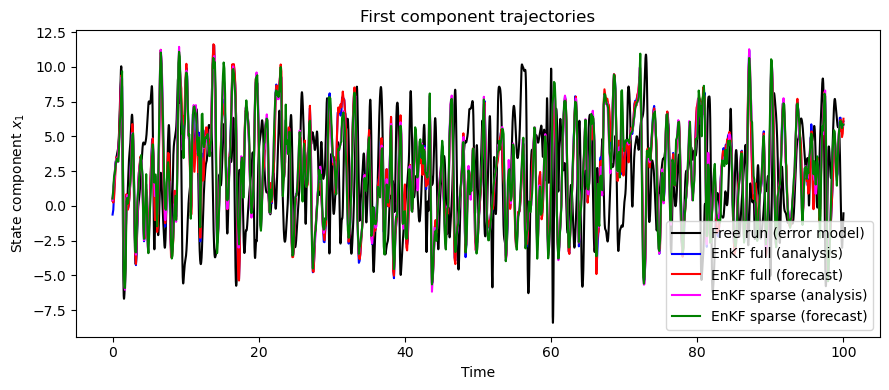

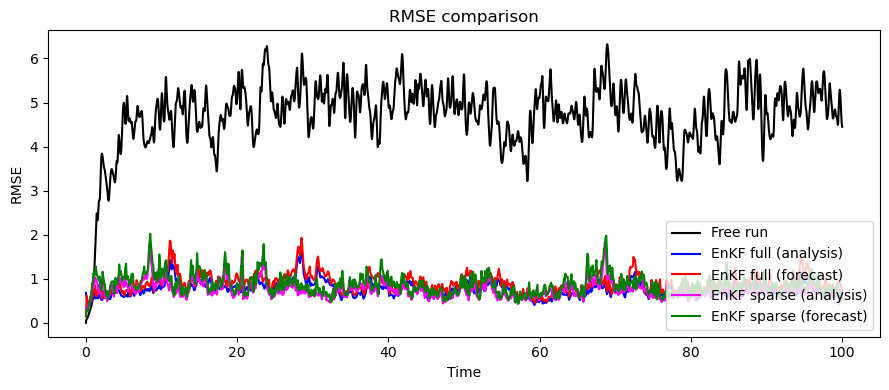

Free run                 : mean RMSE = 4.7245
EnKF full (analysis)     : mean RMSE = 0.7610
EnKF full (forecast)     : mean RMSE = 0.8907
EnKF sparse (analysis)   : mean RMSE = 0.7504
EnKF sparse (forecast)   : mean RMSE = 0.8620

>>> 最小平均 RMSE 的曲线是:
    EnKF sparse (analysis) (mean RMSE = 0.7504)


In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

# =======================================================
# 1. 加载数据
# =======================================================
root = "/Users/huanghongxiao/Desktop/Uchicago/Inverse Problem/HW/acm270_projects-main/Project 4"
sol_dir  = os.path.join(root, "Data", "sol")
enkf_dir = os.path.join(root, "Data", "EnKF")

# ---- 真值 x_truth (40, T) ----
x_truth = np.load(os.path.join(sol_dir, "x_truth.npy"))

# ---- 加载 sol_error.pkl → x_error (free run) ----
with open(os.path.join(sol_dir, "sol_error.pkl"), "rb") as f:
    sol_error = pickle.load(f)
x_error = sol_error.y[:40, :]    # 取前 40 个慢变量

# ---- 加载 EnKF 输出：full & sparse, forecast & analysis ----
x_a_full    = np.load(os.path.join(enkf_dir, "x_a_full.npy"))
x_f_full    = np.load(os.path.join(enkf_dir, "x_f_full.npy"))
x_a_sparse  = np.load(os.path.join(enkf_dir, "x_a_sparse.npy"))
x_f_sparse  = np.load(os.path.join(enkf_dir, "x_f_sparse.npy"))
assim_indices = np.load(os.path.join(enkf_dir, "assim_indices.npy"))

print("x_truth:", x_truth.shape)
print("x_error:", x_error.shape)
print("x_a_full:", x_a_full.shape)
print("x_f_full:", x_f_full.shape)
print("x_a_sparse:", x_a_sparse.shape)
print("x_f_sparse:", x_f_sparse.shape)
print("assim_indices:", assim_indices.shape)

# ---- 时间轴设置 ----
dt = 0.005
T = x_truth.shape[1]
t_full  = np.arange(T) * dt
t_assim = assim_indices * dt


# =======================================================
# 2. 第一张图：第一个分量轨迹对比（5 条曲线）
# =======================================================
plt.figure(figsize=(9, 4))

plt.plot(t_full,  x_error[0, :],
         color="black", label="Free run (error model)")
plt.plot(t_assim, x_a_full[0, :],
         color="blue",  label="EnKF full (analysis)")
plt.plot(t_assim, x_f_full[0, :],
         color="red",   label="EnKF full (forecast)")
plt.plot(t_assim, x_a_sparse[0, :],
         color="magenta", label="EnKF sparse (analysis)")
plt.plot(t_assim, x_f_sparse[0, :],
         color="green", label="EnKF sparse (forecast)")

plt.xlabel("Time")
plt.ylabel("State component $x_1$")
plt.title("First component trajectories")
plt.legend()
plt.tight_layout()
plt.show()


# =======================================================
# 3. 第二张图：5 条 RMSE 曲线
# =======================================================
def rmse(truth, est, axis=0):
    """在给定 axis 上计算 RMSE。"""
    return np.sqrt(np.mean((est - truth) ** 2, axis=axis))


# 对齐后的 truth
truth_full  = x_truth                           # (40, T)
truth_assim = x_truth[:, assim_indices]         # (40, N_assim)

# 五条 RMSE 曲线（按时间算）
rmse_free       = rmse(truth_full,  x_error,     axis=0)  # (T,)
rmse_a_full     = rmse(truth_assim, x_a_full,    axis=0)  # (N_assim,)
rmse_f_full     = rmse(truth_assim, x_f_full,    axis=0)
rmse_a_sparse   = rmse(truth_assim, x_a_sparse,  axis=0)
rmse_f_sparse   = rmse(truth_assim, x_f_sparse,  axis=0)

plt.figure(figsize=(9, 4))

plt.plot(t_full,  rmse_free,
         color="black", label="Free run")
plt.plot(t_assim, rmse_a_full,
         color="blue",  label="EnKF full (analysis)")
plt.plot(t_assim, rmse_f_full,
         color="red",   label="EnKF full (forecast)")
plt.plot(t_assim, rmse_a_sparse,
         color="magenta", label="EnKF sparse (analysis)")
plt.plot(t_assim, rmse_f_sparse,
         color="green", label="EnKF sparse (forecast)")

plt.xlabel("Time")
plt.ylabel("RMSE")
plt.title("RMSE comparison")
plt.legend()
plt.tight_layout()
plt.show()


# =======================================================
# 4. 计算哪条曲线的时间平均 RMSE 最小
# =======================================================
rmse_mean_dict = {
    "Free run":                   rmse_free.mean(),
    "EnKF full (analysis)":       rmse_a_full.mean(),
    "EnKF full (forecast)":       rmse_f_full.mean(),
    "EnKF sparse (analysis)":     rmse_a_sparse.mean(),
    "EnKF sparse (forecast)":     rmse_f_sparse.mean(),
}

for name, val in rmse_mean_dict.items():
    print(f"{name:25s}: mean RMSE = {val:.4f}")

best_name, best_val = min(rmse_mean_dict.items(), key=lambda kv: kv[1])
print("\n>>> 最小平均 RMSE 的曲线是:")
print(f"    {best_name} (mean RMSE = {best_val:.4f})")


Loaded x_truth: (40, 20001)
Loaded free run trajectory: (40, 20001)
Loaded baseline EnKF:
  x_a_full   : (40, 1001)
  x_a_sparse : (40, 1001)
Loaded NN-EnKF:
  x_a_full_nn   : (40, 1001)
  x_a_sparse_nn : (40, 1001)

=== Time-averaged RMSE (analysis, at assimilation times) ===
Free run (over all steps)        : 4.7245
Baseline EnKF full  (analysis)   : 0.7610
Baseline EnKF sparse(analysis)   : 0.7504
NN-EnKF full     (analysis)      : 4.8549
NN-EnKF sparse   (analysis)      : 5.0664


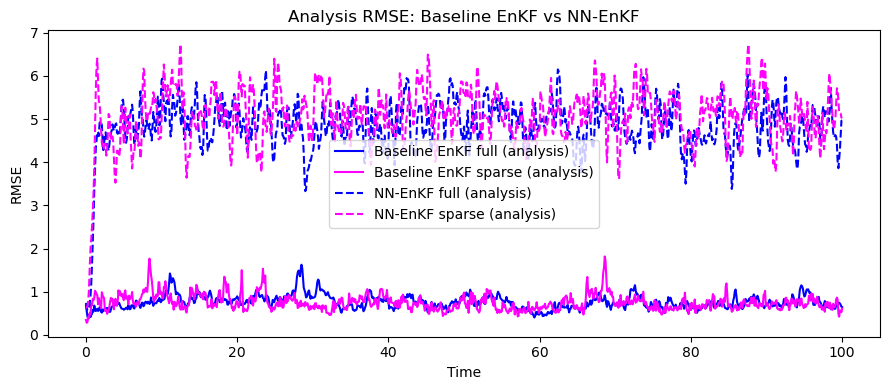


Saved comparison figure to:


In [2]:
#!/usr/bin/env python3
"""
分析 NN-EnKF 效果的脚本：

- 加载 truth, free run, baseline EnKF, NN-EnKF
- 计算 RMSE 曲线
- 打印时间平均 RMSE
- 画 EnKF vs NN-EnKF 分析态的 RMSE 对比图
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

# ------------------------------------------------------------
# 路径设置
# ------------------------------------------------------------
ROOT = "/Users/huanghongxiao/Desktop/Uchicago/Inverse Problem/HW/acm270_projects-main/Project 4"

DATA_DIR   = os.path.join(ROOT, "Data")
SOL_DIR    = os.path.join(DATA_DIR, "sol")
ENKF_DIR   = os.path.join(DATA_DIR, "EnKF")        # baseline EnKF
NN_DIR     = os.path.join(DATA_DIR, "NN_Correct")  # NN-EnKF 结果
OBS_DIR    = os.path.join(DATA_DIR, "Observation")

dt = 0.005

# ------------------------------------------------------------
# 工具函数：RMSE
# ------------------------------------------------------------
def rmse(truth, est, axis=0):
    """在给定 axis 上计算 RMSE"""
    return np.sqrt(np.mean((est - truth) ** 2, axis=axis))


# ------------------------------------------------------------
# 1. 加载真值和 free run
# ------------------------------------------------------------
x_truth = np.load(os.path.join(SOL_DIR, "x_truth.npy"))    # (40, T)
K, T = x_truth.shape
t_full = np.arange(T) * dt

print("Loaded x_truth:", x_truth.shape)

# free run: sol_error.pkl -> x_error
with open(os.path.join(SOL_DIR, "sol_error.pkl"), "rb") as f:
    sol_error = pickle.load(f)
x_error = sol_error.y[:40, :]   # (40, T)
rmse_free = rmse(x_truth, x_error, axis=0)

print("Loaded free run trajectory:", x_error.shape)


# ------------------------------------------------------------
# 2. 加载 baseline EnKF 结果 (Data/EnKF)
# ------------------------------------------------------------
x_a_full    = np.load(os.path.join(ENKF_DIR, "x_a_full.npy"))    # (40, N_assim)
x_a_sparse  = np.load(os.path.join(ENKF_DIR, "x_a_sparse.npy"))  # (40, N_assim)
assim_indices = np.load(os.path.join(ENKF_DIR, "assim_indices.npy"))

N_assim = assim_indices.shape[0]
t_assim = assim_indices * dt

truth_assim = x_truth[:, assim_indices]

rmse_a_full_base   = rmse(truth_assim, x_a_full,   axis=0)
rmse_a_sparse_base = rmse(truth_assim, x_a_sparse, axis=0)

print("Loaded baseline EnKF:")
print("  x_a_full   :", x_a_full.shape)
print("  x_a_sparse :", x_a_sparse.shape)


# ------------------------------------------------------------
# 3. 加载 NN-EnKF 结果 (Data/NN_Correct)
# ------------------------------------------------------------
x_a_full_nn    = np.load(os.path.join(NN_DIR, "x_a_full_nn.npy"))
x_a_sparse_nn  = np.load(os.path.join(NN_DIR, "x_a_sparse_nn.npy"))

rmse_a_full_nn   = rmse(truth_assim, x_a_full_nn,   axis=0)
rmse_a_sparse_nn = rmse(truth_assim, x_a_sparse_nn, axis=0)

print("Loaded NN-EnKF:")
print("  x_a_full_nn   :", x_a_full_nn.shape)
print("  x_a_sparse_nn :", x_a_sparse_nn.shape)


# ------------------------------------------------------------
# 4. 打印时间平均 RMSE
# ------------------------------------------------------------
print("\n=== Time-averaged RMSE (analysis, at assimilation times) ===")
print(f"Free run (over all steps)        : {rmse_free.mean():.4f}")
print(f"Baseline EnKF full  (analysis)   : {rmse_a_full_base.mean():.4f}")
print(f"Baseline EnKF sparse(analysis)   : {rmse_a_sparse_base.mean():.4f}")
print(f"NN-EnKF full     (analysis)      : {rmse_a_full_nn.mean():.4f}")
print(f"NN-EnKF sparse   (analysis)      : {rmse_a_sparse_nn.mean():.4f}")


# ------------------------------------------------------------
# 5. 画图：baseline vs NN-EnKF 的分析态 RMSE
# ------------------------------------------------------------
plt.figure(figsize=(9, 4))

# baseline full / sparse
plt.plot(t_assim, rmse_a_full_base,
         color="blue",  linestyle="-",  label="Baseline EnKF full (analysis)")
plt.plot(t_assim, rmse_a_sparse_base,
         color="magenta", linestyle="-", label="Baseline EnKF sparse (analysis)")

# NN-EnKF full / sparse
plt.plot(t_assim, rmse_a_full_nn,
         color="blue",  linestyle="--", label="NN-EnKF full (analysis)")
plt.plot(t_assim, rmse_a_sparse_nn,
         color="magenta", linestyle="--", label="NN-EnKF sparse (analysis)")

plt.xlabel("Time")
plt.ylabel("RMSE")
plt.title("Analysis RMSE: Baseline EnKF vs NN-EnKF")
plt.legend()
plt.tight_layout()

# 如果你愿意保存图片：
plt.show()

print("\nSaved comparison figure to:")


>>> Loading data from /Users/huanghongxiao/Desktop/Uchicago/Inverse Problem/HW/acm270_projects-main/Project 4/Data/NN_Correct_1 ...
Data loaded. State dim: 40, Assim steps: 1001

Time-Averaged RMSE Summary:
  Full Obs (NN-EnKF):   0.7289
  Sparse Obs (NN-EnKF): 0.7754


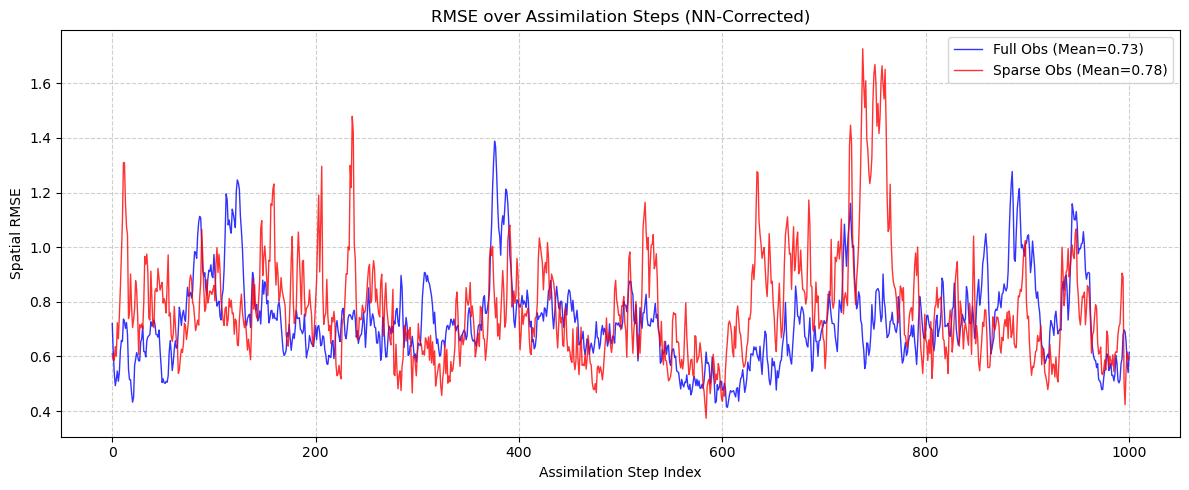

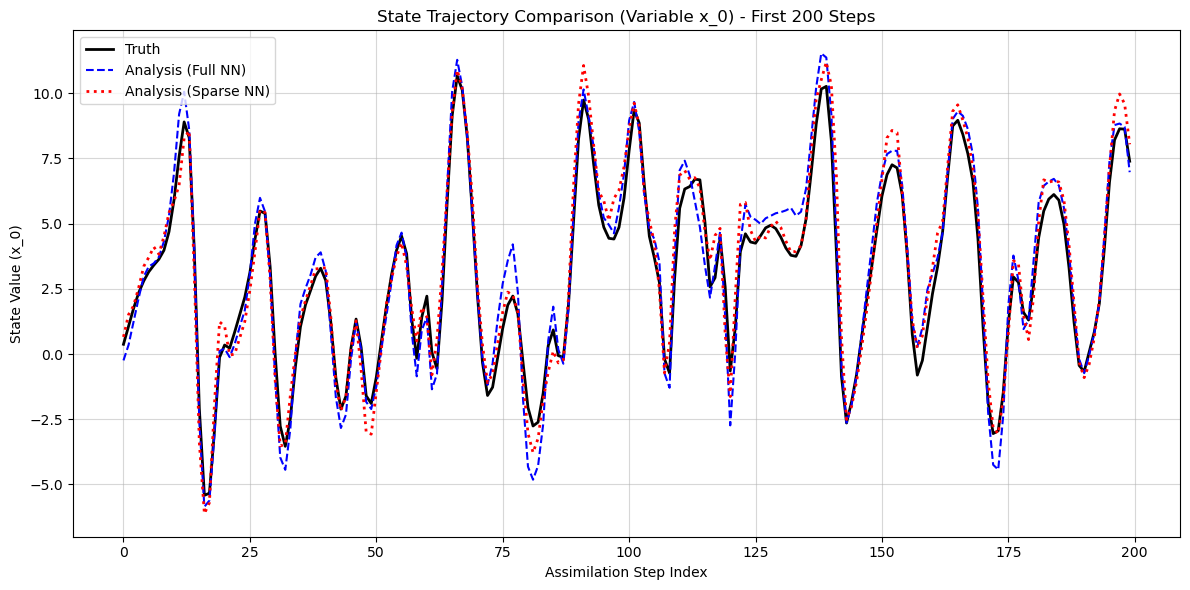

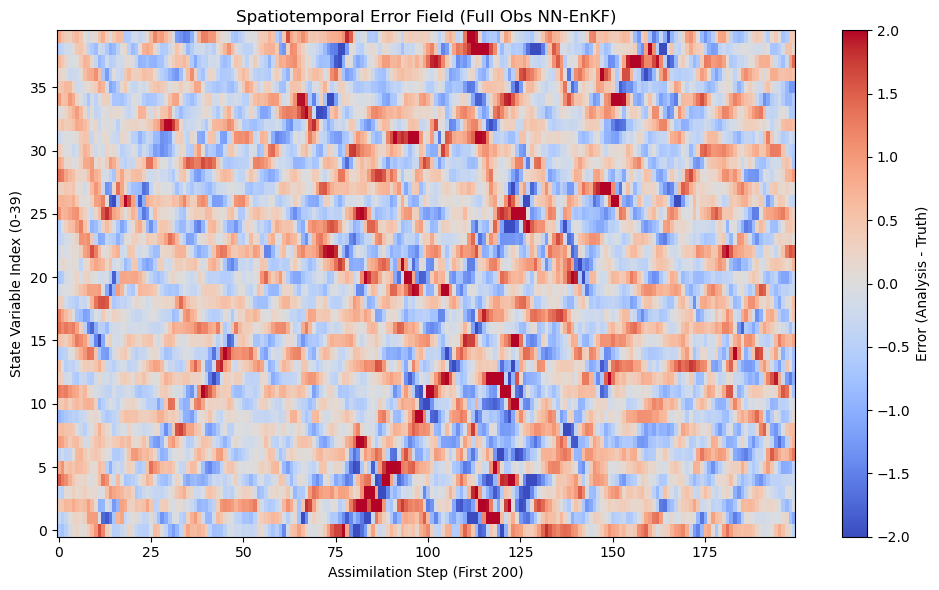

In [3]:
#!/usr/bin/env python3
"""
分析脚本：可视化 NN-EnKF (Project 4) 的结果
功能：
1. 计算并绘制 RMSE 随时间的变化曲线 (Full vs Sparse)
2. 绘制某个状态变量 (如 x_0) 的真实轨迹与分析轨迹对比
3. 输出统计指标
"""

import os
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 1. 路径配置 (需要与之前保持一致)
# ----------------------------------------------------------------------
PROJECT_ROOT = "/Users/huanghongxiao/Desktop/Uchicago/Inverse Problem/HW/acm270_projects-main/Project 4"
DATA_DIR = os.path.join(PROJECT_ROOT, "Data")
SOL_DIR  = os.path.join(DATA_DIR, "sol")
OBS_DIR  = os.path.join(DATA_DIR, "Observation")
OUT_DIR  = os.path.join(DATA_DIR, "NN_Correct_1")  # 结果文件夹

# ----------------------------------------------------------------------
# 2. 加载数据
# ----------------------------------------------------------------------
print(f">>> Loading data from {OUT_DIR} ...")

# 加载 NN-EnKF 结果 (Analysis Mean)
# Shape: (40, N_assim)
try:
    x_a_full   = np.load(os.path.join(OUT_DIR, "x_a_full_nn.npy"))
    x_a_sparse = np.load(os.path.join(OUT_DIR, "x_a_sparse_nn.npy"))
except FileNotFoundError as e:
    print("错误：找不到结果文件。请先运行 'enkf_nn_correct_v2.py' 生成数据。")
    raise e

# 加载真实值 (Truth) 和 同化时间索引
# Truth Shape: (40, 20001) -> 我们需要提取同化时刻的 Truth
x_truth_all = np.load(os.path.join(SOL_DIR, "x_truth.npy"))
assim_indices = np.load(os.path.join(OBS_DIR, "assim_indices.npy"))

# 提取同化时刻的 Truth
# Shape: (40, N_assim)
x_truth_assim = x_truth_all[:, assim_indices]

N_state, N_assim = x_a_full.shape
print(f"Data loaded. State dim: {N_state}, Assim steps: {N_assim}")

# ----------------------------------------------------------------------
# 3. 计算 RMSE (Root Mean Square Error)
# ----------------------------------------------------------------------
# 也就是计算所有状态变量在每个时刻的平均误差
# axis=0 表示对 40 个状态变量求平均
rmse_time_full   = np.sqrt(np.mean((x_a_full   - x_truth_assim)**2, axis=0))
rmse_time_sparse = np.sqrt(np.mean((x_a_sparse - x_truth_assim)**2, axis=0))

# 计算时间平均 RMSE (全局指标)
mean_rmse_full   = np.mean(rmse_time_full)
mean_rmse_sparse = np.mean(rmse_time_sparse)

print("\n" + "="*40)
print(f"Time-Averaged RMSE Summary:")
print(f"  Full Obs (NN-EnKF):   {mean_rmse_full:.4f}")
print(f"  Sparse Obs (NN-EnKF): {mean_rmse_sparse:.4f}")
print("="*40)

# ----------------------------------------------------------------------
# 4. 绘图 1: RMSE 随时间的变化
# ----------------------------------------------------------------------
plt.figure(figsize=(12, 5))
time_steps = np.arange(N_assim)

plt.plot(time_steps, rmse_time_full,   label=f'Full Obs (Mean={mean_rmse_full:.2f})',   color='blue', alpha=0.8, linewidth=1)
plt.plot(time_steps, rmse_time_sparse, label=f'Sparse Obs (Mean={mean_rmse_sparse:.2f})', color='red',  alpha=0.8, linewidth=1)

plt.title("RMSE over Assimilation Steps (NN-Corrected)")
plt.xlabel("Assimilation Step Index")
plt.ylabel("Spatial RMSE")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 5. 绘图 2: 状态轨迹对比 (前 200 步)
# ----------------------------------------------------------------------
# 我们只画第一个变量 (State Index 0) 来看细节
var_idx = 0
plot_steps = 200  # 只看前200步，看得更清楚

plt.figure(figsize=(12, 6))

# 真实值 (黑色实线)
plt.plot(time_steps[:plot_steps], x_truth_assim[var_idx, :plot_steps],
         'k-', linewidth=2, label='Truth')

# Full Obs (蓝色虚线)
plt.plot(time_steps[:plot_steps], x_a_full[var_idx, :plot_steps],
         'b--', label='Analysis (Full NN)')

# Sparse Obs (红色点线)
plt.plot(time_steps[:plot_steps], x_a_sparse[var_idx, :plot_steps],
         'r:', linewidth=2, label='Analysis (Sparse NN)')

plt.title(f"State Trajectory Comparison (Variable x_{var_idx}) - First {plot_steps} Steps")
plt.xlabel("Assimilation Step Index")
plt.ylabel(f"State Value (x_{var_idx})")
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 6. 绘图 3: Hovemoller Diagram (可选，查看时空演变)
# ----------------------------------------------------------------------
# 绘制全量观测下的误差分布图 (Error Field)
error_field = x_a_full - x_truth_assim

plt.figure(figsize=(10, 6))
# 只画前 200 步，避免图太密
plt.imshow(error_field[:, :200], aspect='auto', cmap='coolwarm', origin='lower', vmin=-2, vmax=2)
plt.colorbar(label="Error (Analysis - Truth)")
plt.xlabel("Assimilation Step (First 200)")
plt.ylabel("State Variable Index (0-39)")
plt.title("Spatiotemporal Error Field (Full Obs NN-EnKF)")
plt.tight_layout()
plt.show()

>>> Loading comparison data...
  Offline NN data loaded.
  AD-EnKF data loaded. Shape: (40, 1001)

RESULTS SUMMARY (RMSE):
  Offline NN (Baseline): 0.7289
  AD-EnKF (End-to-End):  0.8596


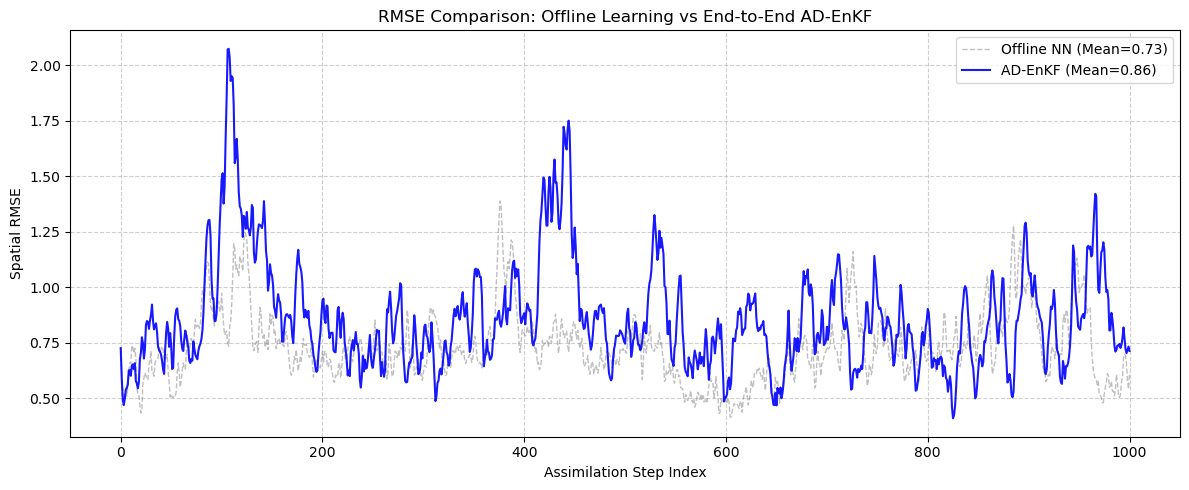

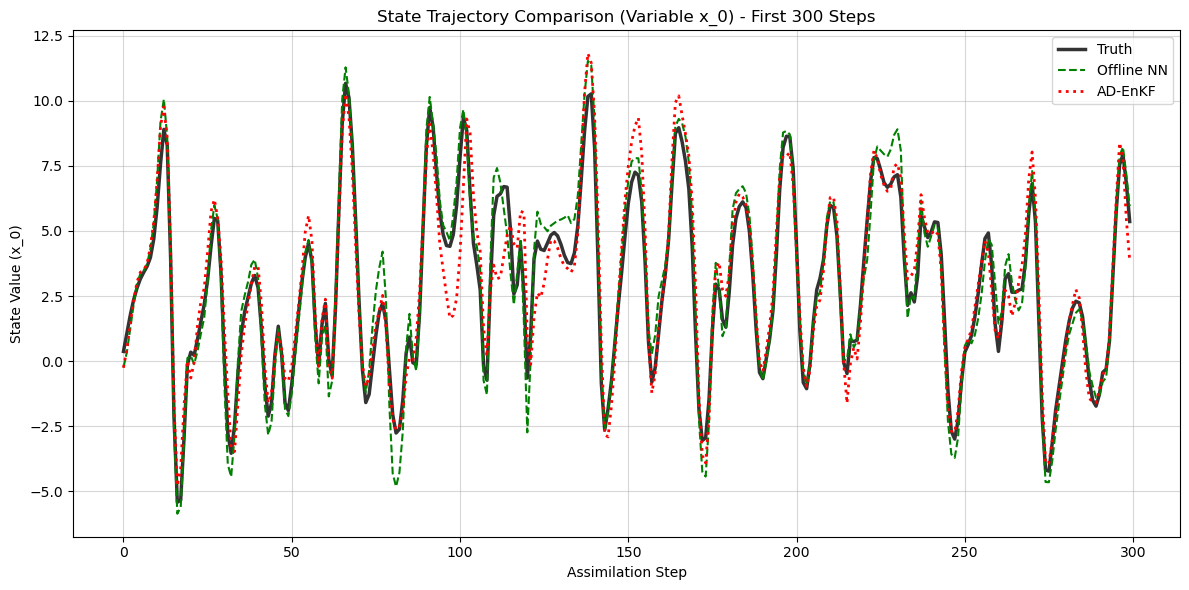

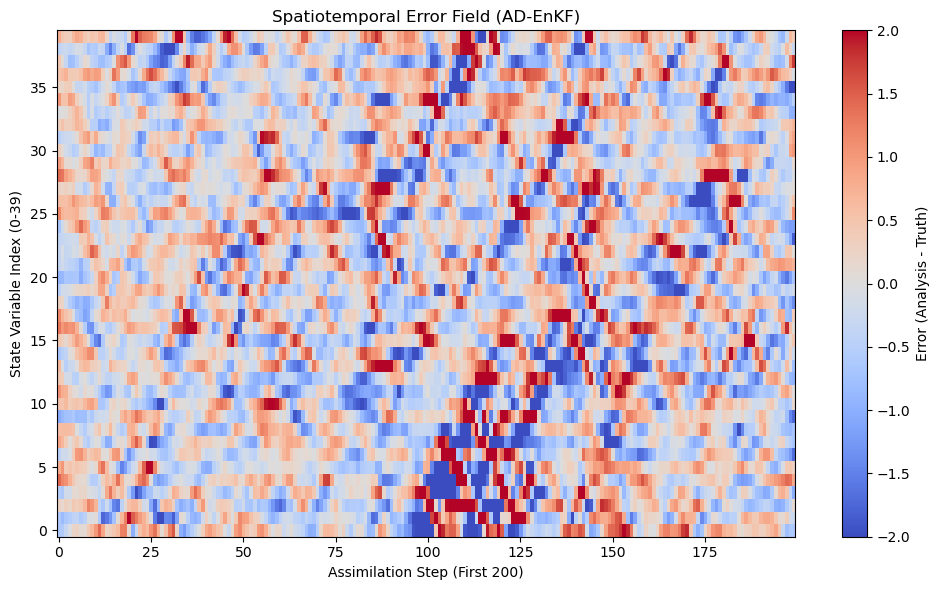

In [4]:
#!/usr/bin/env python3
"""
分析脚本：AD-EnKF (JAX) 结果可视化与对比
功能：
1. 对比 Offline NN (Full Obs) 和 AD-EnKF (End-to-End) 的 RMSE。
2. 绘制状态轨迹对比 (Truth vs Offline vs AD-EnKF)。
3. 生成误差热图。
"""

import os
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 1. 路径配置
# ----------------------------------------------------------------------
PROJECT_ROOT = "/Users/huanghongxiao/Desktop/Uchicago/Inverse Problem/HW/acm270_projects-main/Project 4"
DATA_DIR = os.path.join(PROJECT_ROOT, "Data")
SOL_DIR  = os.path.join(DATA_DIR, "sol")
OBS_DIR  = os.path.join(DATA_DIR, "Observation")

# 结果文件夹
OFFLINE_DIR = os.path.join(DATA_DIR, "NN_Correct_1") # 存放之前的 Offline NN 结果
AD_DIR      = os.path.join(DATA_DIR, "EnKF_jax")     # 存放新的 JAX AD-EnKF 结果

# ----------------------------------------------------------------------
# 2. 加载数据
# ----------------------------------------------------------------------
print(f">>> Loading comparison data...")

# 1. Truth & Indices
x_truth_all = np.load(os.path.join(SOL_DIR, "x_truth.npy"))
assim_indices = np.load(os.path.join(OBS_DIR, "assim_indices.npy"))
x_truth_assim = x_truth_all[:, assim_indices] # (40, N_assim)

# 2. Offline NN Result (Full Obs) - Previous Best
try:
    x_a_offline = np.load(os.path.join(OFFLINE_DIR, "x_a_full_nn.npy"))
    print("  Offline NN data loaded.")
except FileNotFoundError:
    print("  [Warning] Offline NN data not found. Skipping comparison.")
    x_a_offline = None

# 3. AD-EnKF Result (JAX)
try:
    x_a_ad = np.load(os.path.join(AD_DIR, "x_a_ad_enkf.npy"))
    # 注意：JAX 脚本保存时可能已经是 (40, N_assim) 或者 (N_assim, 40)
    # 我们之前的脚本是保存为 (N_assim, 40) 然后转置保存，或者是直接保存。
    # 让我们检查一下 shape。通常习惯是 (40, N_assim) 用于绘图。
    if x_a_ad.shape[0] != 40:
        x_a_ad = x_a_ad.T
    print(f"  AD-EnKF data loaded. Shape: {x_a_ad.shape}")
except FileNotFoundError:
    raise FileNotFoundError("AD-EnKF result not found. Run 'ad_enkf_jax.py' first.")

N_state, N_assim = x_truth_assim.shape

# ----------------------------------------------------------------------
# 3. 计算 RMSE
# ----------------------------------------------------------------------
# RMSE over time (spatial average)
rmse_time_ad = np.sqrt(np.mean((x_a_ad - x_truth_assim)**2, axis=0))
mean_rmse_ad = np.mean(rmse_time_ad)

rmse_time_offline = None
mean_rmse_offline = None

if x_a_offline is not None:
    rmse_time_offline = np.sqrt(np.mean((x_a_offline - x_truth_assim)**2, axis=0))
    mean_rmse_offline = np.mean(rmse_time_offline)

print("\n" + "="*40)
print(f"RESULTS SUMMARY (RMSE):")
if mean_rmse_offline:
    print(f"  Offline NN (Baseline): {mean_rmse_offline:.4f}")
print(f"  AD-EnKF (End-to-End):  {mean_rmse_ad:.4f}")
print("="*40)

# ----------------------------------------------------------------------
# 4. 绘图 1: RMSE 随时间变化对比
# ----------------------------------------------------------------------
plt.figure(figsize=(12, 5))
time_steps = np.arange(N_assim)

if rmse_time_offline is not None:
    plt.plot(time_steps, rmse_time_offline, label=f'Offline NN (Mean={mean_rmse_offline:.2f})',
             color='gray', alpha=0.5, linewidth=1, linestyle='--')

plt.plot(time_steps, rmse_time_ad, label=f'AD-EnKF (Mean={mean_rmse_ad:.2f})',
         color='blue', alpha=0.9, linewidth=1.5)

plt.title("RMSE Comparison: Offline Learning vs End-to-End AD-EnKF")
plt.xlabel("Assimilation Step Index")
plt.ylabel("Spatial RMSE")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 5. 绘图 2: 轨迹对比 (前 300 步)
# ----------------------------------------------------------------------
var_idx = 0 # 查看第0个变量
plot_steps = 300

plt.figure(figsize=(12, 6))

# Truth
plt.plot(time_steps[:plot_steps], x_truth_assim[var_idx, :plot_steps],
         'k-', linewidth=2.5, alpha=0.8, label='Truth')

# Offline
if x_a_offline is not None:
    plt.plot(time_steps[:plot_steps], x_a_offline[var_idx, :plot_steps],
             'g--', linewidth=1.5, label='Offline NN')

# AD-EnKF
plt.plot(time_steps[:plot_steps], x_a_ad[var_idx, :plot_steps],
         'r:', linewidth=2.0, label='AD-EnKF')

plt.title(f"State Trajectory Comparison (Variable x_{var_idx}) - First {plot_steps} Steps")
plt.xlabel("Assimilation Step")
plt.ylabel(f"State Value (x_{var_idx})")
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 6. 绘图 3: 误差热图 (AD-EnKF)
# ----------------------------------------------------------------------
# 绘制误差分布图，看看误差主要集中在哪里
error_field = x_a_ad - x_truth_assim

plt.figure(figsize=(10, 6))
# 限制展示前 200 步，避免太密集
im = plt.imshow(error_field[:, :200], aspect='auto', cmap='coolwarm', origin='lower', vmin=-2, vmax=2)
plt.colorbar(im, label="Error (Analysis - Truth)")
plt.xlabel("Assimilation Step (First 200)")
plt.ylabel("State Variable Index (0-39)")
plt.title("Spatiotemporal Error Field (AD-EnKF)")
plt.tight_layout()
plt.show()